In [1]:
!ls

README.md  data_tensor.pt  experiment.ipynb  main.py
app	   dataset	   labels_tensor.pt  requirements.txt


In [2]:
import pandas as pd
from PIL import Image
import os

In [7]:
annotations_path = "./dataset/combined_annotations.csv"

In [8]:
annotations = pd.read_csv(annotations_path)

In [9]:
annotations.head()

,file_path,label,season_id,survey_id
0,./combined_dataset\20130718_210056.jpg,4,2,1
1,./combined_dataset\20130718_210056_001.jpg,4,2,1
2,./combined_dataset\20130718_210056_002.jpg,4,2,1
3,./combined_dataset\20130718_210110.jpg,4,2,1
4,./combined_dataset\20130718_210628.jpg,4,2,1


In [12]:
annotations['file_path'] = annotations['file_path'].str.replace('\\', '/', regex=False)


In [15]:
annotations['file_path'] = "./dataset/" + annotations['file_path'] 

In [10]:
def load_image(file_path):
    try:
        # Открыть изображение с использованием PIL
        with Image.open(file_path) as img:
            img = img.convert("RGB")  # Преобразование в формат RGB
            return img
    except Exception as e:
        print(f"Ошибка при загрузке изображения {file_path}: {e}")
        return None

In [16]:
for _, row in annotations.iterrows():
    file_path = row['file_path']
    label = row['label']  # Метка (идентификатор лисы)
    
    # Проверка наличия файла
    if os.path.exists(file_path):
        image = load_image(file_path)
        print(f"Загружено изображение {file_path} с меткой {label}")
    else:
        print(f"Файл не найден: {file_path}")

Загружено изображение ./dataset/./combined_dataset/20130718_210056.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210056_001.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210056_002.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210110.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210628.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210628_001.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210628_002.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210653.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210653_001.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_210653_002.jpg с меткой 4
Загружено изображение ./dataset/./combined_dataset/20130718_211936.jpg с меткой 3
Загружено изображение ./dataset/./combined_dataset/20130718_211936_001.jpg

KeyboardInterrupt: 

In [28]:
from torchvision import transforms
import torch

In [29]:
# Пример преобразований изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера
    transforms.ToTensor(),         # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

In [19]:
data = []
labels = []

In [20]:
for _, row in annotations.iterrows():
    file_path = row['file_path']
    label = row['label']
    
    if os.path.exists(file_path):
        image = load_image(file_path)
        if image:
            image = transform(image)  # Применение преобразований
            data.append(image)
            labels.append(label)

In [21]:
data_tensor = torch.stack(data)
labels_tensor = torch.tensor(labels)

In [22]:
print(f"Размер данных: {data_tensor.shape}")
print(f"Размер меток: {labels_tensor.shape}")

Размер данных: torch.Size([12478, 3, 224, 224])
Размер меток: torch.Size([12478])


In [3]:
data_tensor_path = "data_tensor.pt"
labels_tensor_path = "labels_tensor.pt"

In [24]:
torch.save(data_tensor, data_tensor_path)
torch.save(labels_tensor, labels_tensor_path)

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

In [5]:
data_tensor_path = "data_tensor.pt"
labels_tensor_path = "labels_tensor.pt"

In [6]:
data_tensor = torch.load(data_tensor_path)
labels_tensor = torch.load(labels_tensor_path)

/tmp/ipykernel_1304/1818967108.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_tensor = torch.load(data_tensor_path)
/tmp/ipykernel_1304/1818967108.py:2: FutureWarn

In [7]:
print(f"Размер данных: {data_tensor.shape}")
print(f"Размер меток: {labels_tensor.shape}")

Размер данных: torch.Size([12478, 3, 224, 224])
Размер меток: torch.Size([12478])


In [8]:
# Найти самое частое значение в labels_tensor
selected_label = labels_tensor.bincount().argmax().item()
print(f"Самая частая метка: {selected_label}")

Самая частая метка: 3


In [10]:
data_loader = DataLoader(TensorDataset(data_tensor, labels_tensor), batch_size=32, shuffle=True)

In [11]:
bin_label_tensor = (labels_tensor == selected_label).int()

In [12]:
torch.cuda.is_available()

True

In [50]:
# Определение модели
model = models.resnet50(pretrained=True)  # Используем ResNet-18
model.fc = nn.Linear(model.fc.in_features, 1)  # Бинарная классификация
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

/home/ubuntu/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

00%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 79.0MB/s]

In [51]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model, data_loader, criterion, optimizer, num_epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_losses = []
    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_preds = []
        all_labels = []

        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).float()

            # Forward
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss /= len(data_loader.dataset)

        # Преобразование меток в бинарные, если требуется
        all_preds = [1 if p == 1 else 0 for p in all_preds]
        all_labels = [1 if l == 1 else 0 for l in all_labels]

        # Вычисление метрик
        precision = precision_score(all_labels, all_preds, average='binary')
        recall = recall_score(all_labels, all_preds, average='binary')
        f1 = f1_score(all_labels, all_preds, average='binary')
        accuracy = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)

        train_losses.append(train_loss)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    # Визуализация метрик
    plt.figure(figsize=(12, 5))
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, precisions, label='Precision', color='blue')
    plt.plot(epochs, recalls, label='Recall', color='orange')
    plt.plot(epochs, f1_scores, label='F1-Score', color='green')
    plt.plot(epochs, accuracies, label='Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training Metrics')
    plt.legend()
    plt.show()


Epoch 1/10: Train Loss: -4046.7013, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 2/10: Train Loss: -9011.0513, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 3/10: Train Loss: -15222.4239, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 4/10: Train Loss: -22714.8449, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 5/10: Train Loss: -31523.4490, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 6/10: Train Loss: -41975.3444, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 7/10: Train Loss: -52912.2242, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 8/10: Train Loss: -65586.9612, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 9/10: Train Loss: -78938.8884, Precision: 0.1451, Recall: 1.0000, F1-Score: 0.2535, Accuracy: 0.1451
Epoch 10/10: Train Loss: -93410.1408, P

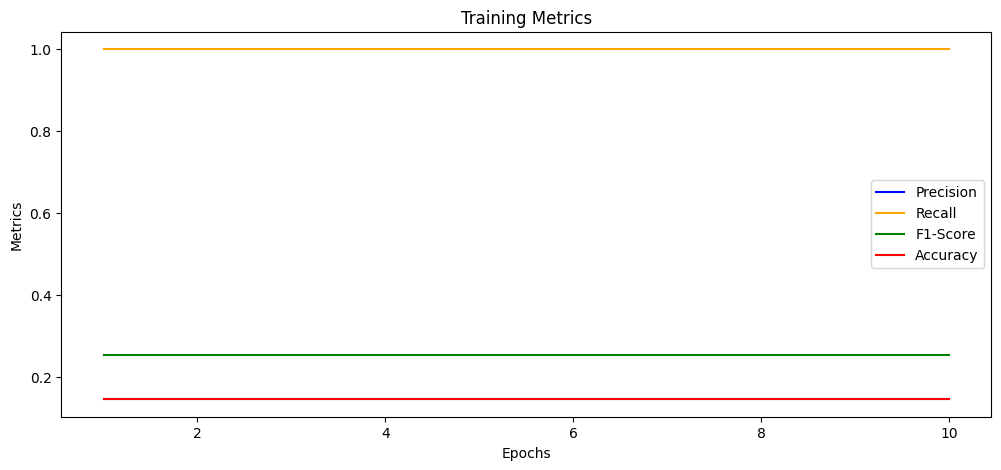

In [56]:
train_model(model, data_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10: Train Loss: -20330.7640, Accuracy: 0.1451
Epoch 2/10: Train Loss: -23402.9917, Accuracy: 0.1451
Epoch 3/10: Train Loss: -26615.5679, Accuracy: 0.1451
Epoch 4/10: Train Loss: -29775.4627, Accuracy: 0.1451
Epoch 5/10: Train Loss: -33329.6187, Accuracy: 0.1451
Epoch 6/10: Train Loss: -37034.0782, Accuracy: 0.1451
Epoch 7/10: Train Loss: -40850.5045, Accuracy: 0.1451
Epoch 8/10: Train Loss: -44927.4940, Accuracy: 0.1451
Epoch 9/10: Train Loss: -49141.7072, Accuracy: 0.1451
Epoch 10/10: Train Loss: -53316.0736, Accuracy: 0.1451


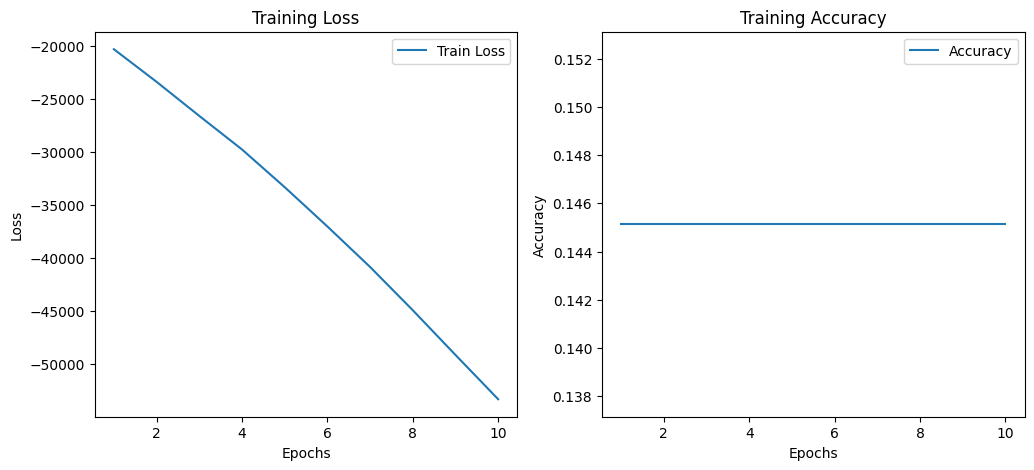

In [19]:
train_model(model, data_loader, criterion, optimizer, num_epochs=10)

In [41]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import numpy as np
from PIL import Image
import cv2

In [57]:
# Выберите слой, который хотите визуализировать
target_layer = model.layer4[-1]  # Последний слой ResNet перед классификацией

In [58]:
# Инициализация Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])

In [59]:

image_path = "./dataset/./combined_dataset/20130718_211936.jpg"
pil_image = Image.open(image_path).convert('RGB')
input_tensor = transform(pil_image).unsqueeze(0)  # Преобразование изображения
input_tensor = input_tensor.to("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
# Вычисление Grad-CAM
with cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)  # Можно задать конкретный target
grayscale_cam = grayscale_cam[0, :]  # Извлекаем карту для первого изображения в батче

In [61]:
# Преобразование изображения в массив
rgb_image = np.array(pil_image) / 255.0  # Нормализация для отображения

In [62]:
# Изменение размера grayscale_cam до размеров оригинального изображения
grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_image.shape[1], rgb_image.shape[0]))


In [63]:
# Наложение карты активации на изображение
cam_image = show_cam_on_image(rgb_image, grayscale_cam_resized, use_rgb=True)

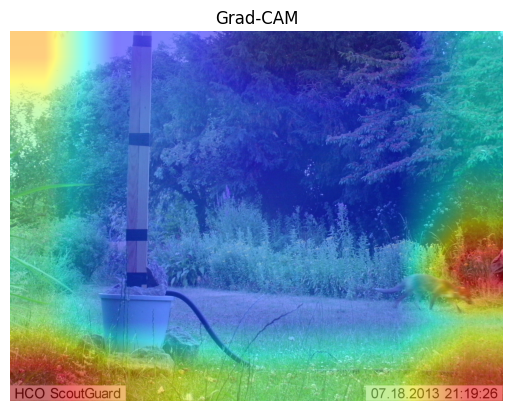

In [64]:
# Отображение Grad-CAM
plt.imshow(cam_image)
plt.title("Grad-CAM")
plt.axis("off")
plt.show()